In [1]:
import os
import gc
import numpy as np
import pandas as pd
import tensorflow as tf
import zipfile
import glob
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import MaxPooling2D, Dropout, Dense, Flatten, Add
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard, CSVLogger
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from datetime import datetime
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from pathlib import Path 

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
print("TensorFlow version:", tf.__version__)
print("GPU Available: ", "Yes" if tf.config.list_physical_devices('GPU') else "No")

TensorFlow version: 2.19.0
GPU Available:  No


In [4]:
# Function to extract a zip file if needed
def extract_zip_if_needed(zip_path, extract_to):
    """Extract a zip file if it hasn't been extracted yet."""
    if not os.path.exists(extract_to):
        print(f"Creating directory {extract_to} and extracting {zip_path}...")
        os.makedirs(extract_to, exist_ok=True)
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print("Extraction complete!")
    else:
        print(f"Directory {extract_to} already exists. Skipping extraction.")

In [5]:
# Function to find the UTKFace dataset path
def find_dataset_path(base_path):
    """Find the UTKFace dataset path."""
    # Check if the base path itself contains images
    if any(Path(base_path).glob('*.jpg')) or any(Path(base_path).glob('*.JPG')) or any(Path(base_path).glob('*.png')):
        return base_path
    
    # Look for subdirectories with images
    for subdir in os.listdir(base_path):
        subdir_path = os.path.join(base_path, subdir)
        if os.path.isdir(subdir_path):
            if any(Path(subdir_path).glob('*.jpg')) or any(Path(subdir_path).glob('*.JPG')) or any(Path(subdir_path).glob('*.png')):
                return subdir_path
    
    # Look deeper (up to one more level)
    for subdir in os.listdir(base_path):
        subdir_path = os.path.join(base_path, subdir)
        if os.path.isdir(subdir_path):
            for subsubdir in os.listdir(subdir_path):
                subsubdir_path = os.path.join(subdir_path, subsubdir)
                if os.path.isdir(subsubdir_path):
                    if any(Path(subsubdir_path).glob('*.jpg')) or any(Path(subsubdir_path).glob('*.JPG')) or any(Path(subsubdir_path).glob('*.png')):
                        return subsubdir_path
    
    return None

In [6]:
# Function to extract age, gender, and ethnicity from the filename
def extract_info_from_filename(filename):
    """Extract age, gender, and ethnicity from the filename."""
    try:
        parts = os.path.basename(filename).split('_')
        if len(parts) >= 3:
            age = int(parts[0])
            gender = int(parts[1])
            ethnicity = int(parts[2])
            return age, gender, ethnicity
        return None, None, None
    except:
        return None, None, None

In [7]:
# Function to convert ages to age groups
def convert_to_age_groups(age):
    """Convert age to an age group category."""
    if age <= 12:
        return 0  # Child: 0-12
    elif age <= 18:
        return 1  # Teen: 13-18
    elif age <= 30:
        return 2  # Young Adult: 19-30
    elif age <= 45:
        return 3  # Adult: 31-45
    elif age <= 60:
        return 4  # Middle Age: 46-60
    else:
        return 5  # Senior: 60+

In [8]:
def build_enhanced_model(num_classes, input_shape=(128, 128, 3)):
    """
    Build an enhanced CNN model for age classification with:
    - Deeper architecture with residual connections
    - Improved regularization
    - More efficient use of parameters
    """
    # Input layer
    inputs = Input(shape=input_shape)
    
    # Initial convolution
    x = Conv2D(32, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # First block with residual connection
    residual = x
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, residual])  # Residual connection
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.2)(x)
    
    # Second block with residual connection
    residual = Conv2D(64, (1, 1), strides=(1, 1), padding='same')(x)  # Match dimensions
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, residual])  # Residual connection
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)
    
    # Third block with residual connection
    residual = Conv2D(128, (1, 1), strides=(1, 1), padding='same')(x)  # Match dimensions
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, residual])  # Residual connection
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)
    
    # Fourth block (deeper)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)
    
    # Global average pooling instead of flatten (reduces parameters)
    x = GlobalAveragePooling2D()(x)
    
    # Fully connected layers
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    
    # Use a fixed learning rate instead of a schedule
    # This allows ReduceLROnPlateau to work properly
    model.compile(
        optimizer=Adam(learning_rate=0.001),  # Fixed learning rate
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [9]:
# Improved visualization functions
def plot_training_history(history, output_dir):
    """Plot training history with better visualization"""
    plt.figure(figsize=(16, 6))
    
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.axhline(y=max(history.history['val_accuracy']), color='r', linestyle='--', 
               label=f'Best val_acc: {max(history.history["val_accuracy"]):.4f}')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation', 'Best Validation'], loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.axhline(y=min(history.history['val_loss']), color='r', linestyle='--',
               label=f'Best val_loss: {min(history.history["val_loss"]):.4f}')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation', 'Best Validation'], loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'training_history.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # If learning rate was tracked, plot it
    if 'learning_rate' in history.history:
        plt.figure(figsize=(8, 3))
        plt.plot(history.history['learning_rate'])
        plt.title('Learning Rate Schedule')
        plt.ylabel('Learning Rate')
        plt.xlabel('Epoch')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.savefig(os.path.join(output_dir, 'learning_rate.png'), dpi=300, bbox_inches='tight')
        plt.show()

In [10]:
# Function to create data generators
def create_data_generators(dataset_path, batch_size=32, img_size=(128, 128)):
    """
    Create memory-efficient data generators for training, validation, and testing.
    Processes images in batches rather than loading all into memory.
    """
    # Create a DataFrame with filenames and labels
    image_files = []
    for ext in ['*.jpg', '*.JPG', '*.png']:
        image_files.extend(glob.glob(os.path.join(dataset_path, ext)))
    
    print(f"Found {len(image_files)} image files")
    
    data = []
    for file in tqdm(image_files, desc="Processing image files"):
        age, gender, ethnicity = extract_info_from_filename(file)
        if age is not None:
            age_group = convert_to_age_groups(age)
            data.append({'filename': file, 'age': age, 'age_group': age_group})
    
    df = pd.DataFrame(data)
    
    if len(df) == 0:
        raise ValueError("No valid image files found in the dataset path")
    
    print(f"Successfully processed {len(df)} valid images")
    
    # Display age distribution
    plt.figure(figsize=(14, 6))
    
    # Raw age histogram
    plt.subplot(1, 2, 1)
    plt.hist(df['age'], bins=100, alpha=0.7)
    plt.title('Raw Age Distribution')
    plt.xlabel('Age')
    plt.ylabel('Count')
    
    # Age group distribution
    class_names = ['Child (0-12)', 'Teen (13-18)', 'Young Adult (19-30)', 
                   'Adult (31-45)', 'Middle Age (46-60)', 'Senior (60+)']
    
    plt.subplot(1, 2, 2)
    sns.countplot(x='age_group', data=df)
    plt.title('Age Groups Distribution')
    plt.xlabel('Age Group')
    plt.ylabel('Count')
    plt.xticks(range(6), class_names, rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Split data into train, validation, and test sets
    train_val_df, test_df = train_test_split(df, test_size=0.15, random_state=42, stratify=df['age_group'])
    train_df, val_df = train_test_split(train_val_df, test_size=0.15, random_state=42, stratify=train_val_df['age_group'])
    
    print(f"Training set: {len(train_df)} images")
    print(f"Validation set: {len(val_df)} images")
    print(f"Test set: {len(test_df)} images")
    
    # Display some sample images
    plt.figure(figsize=(15, 8))
    sample_rows = train_df.sample(min(10, len(train_df)))
    for i, (_, row) in enumerate(sample_rows.iterrows()):
        try:
            img = Image.open(row['filename'])
            img = img.resize(img_size)
            plt.subplot(2, 5, i+1)
            plt.imshow(img)
            plt.title(f"Age: {row['age']}\n{class_names[row['age_group']]}")
            plt.axis('off')
        except Exception as e:
            print(f"Error displaying image {row['filename']}: {e}")
    plt.tight_layout()
    plt.show()
    
    # FIXED: Custom data generator with proper super initialization
    class ImageDataGenerator(tf.keras.utils.Sequence):
        def __init__(self, dataframe, batch_size=32, img_size=(128, 128), 
                     num_classes=6, is_train=False, **kwargs):
            super().__init__(**kwargs)  # Fixed: Added super().__init__ call
            self.df = dataframe.copy()
            self.batch_size = batch_size
            self.img_size = img_size
            self.num_classes = num_classes
            self.is_train = is_train
            self.indices = np.arange(len(self.df))
            
        def __len__(self):
            return int(np.ceil(len(self.df) / self.batch_size))
        
        def on_epoch_end(self):
            if self.is_train:
                np.random.shuffle(self.indices)
        
        def __getitem__(self, idx):
            # FIXED: Ensure we don't exceed the dataframe length
            start_idx = idx * self.batch_size
            end_idx = min(start_idx + self.batch_size, len(self.df))
            batch_indices = self.indices[start_idx:end_idx]
            batch_df = self.df.iloc[batch_indices]
            
            batch_x = np.zeros((len(batch_df), self.img_size[0], self.img_size[1], 3), dtype=np.float32)
            batch_y = np.zeros((len(batch_df), self.num_classes), dtype=np.float32)
            
            for i, (_, row) in enumerate(batch_df.iterrows()):
                try:
                    img = Image.open(row['filename'])
                    img = img.resize(self.img_size)
                    img_array = np.array(img) / 255.0
                    
                    # Only include RGB images (3 channels)
                    if len(img_array.shape) == 3 and img_array.shape[2] == 3:
                        batch_x[i] = img_array
                        batch_y[i] = tf.keras.utils.to_categorical(row['age_group'], num_classes=self.num_classes)
                except Exception as e:
                    print(f"Error processing {row['filename']}: {e}")
            
            # Data augmentation for training
            if self.is_train:
                for i in range(len(batch_x)):
                    # Random horizontal flip
                    if np.random.random() > 0.5:
                        batch_x[i] = np.fliplr(batch_x[i])
                    
                    # Random rotation (up to 20 degrees)
                    angle = np.random.uniform(-20, 20)
                    batch_x[i] = tf.keras.preprocessing.image.apply_affine_transform(
                        batch_x[i], theta=angle, fill_mode='nearest')
                    
                    # Random zoom (up to 20%)
                    zoom = np.random.uniform(0.8, 1.2)
                    batch_x[i] = tf.keras.preprocessing.image.apply_affine_transform(
                        batch_x[i], zx=zoom, zy=zoom, fill_mode='nearest')
            
            return batch_x, batch_y
    
    # Create generators
    train_gen = ImageDataGenerator(train_df, batch_size, img_size, num_classes=6, is_train=True)
    val_gen = ImageDataGenerator(val_df, batch_size, img_size, num_classes=6, is_train=False)
    test_gen = ImageDataGenerator(test_df, batch_size, img_size, num_classes=6, is_train=False)
    
    return train_gen, val_gen, test_gen, len(train_df), len(val_df), len(test_df), df

In [11]:
def plot_confusion_matrix(y_true, y_pred, class_names, output_dir):
    """Plot confusion matrix with improved visualization"""
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Normalize confusion matrix
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # Plot raw counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, ax=ax1)
    ax1.set_title('Confusion Matrix (Counts)')
    ax1.set_xlabel('Predicted Label')
    ax1.set_ylabel('True Label')
    ax1.set_xticklabels(class_names, rotation=45, ha='right')
    ax1.set_yticklabels(class_names, rotation=0)
    
    # Plot normalized percentages
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', cbar=True, ax=ax2)
    ax2.set_title('Confusion Matrix (Normalized)')
    ax2.set_xlabel('Predicted Label')
    ax2.set_ylabel('True Label')
    ax2.set_xticklabels(class_names, rotation=45, ha='right')
    ax2.set_yticklabels(class_names, rotation=0)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
    plt.show()

In [12]:
def plot_roc_curves(y_true, y_scores, class_names, output_dir):
    """Plot ROC curves for each class using one-vs-rest approach"""
    # Convert true labels to one-hot encoding
    y_true_onehot = tf.keras.utils.to_categorical(y_true, num_classes=len(class_names))
    
    # Create figure
    plt.figure(figsize=(10, 8))
    
    # Colors for different classes
    colors = plt.cm.tab10.colors
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)], lw=2,
                label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
    
    # Plot diagonal line (random classifier)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    
    # Set plot properties
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'roc_curves.png'), dpi=300, bbox_inches='tight')
    plt.show()

In [13]:
# Improved function for predicting on new images
def predict_age_group(model, image_path, class_names):
    """
    Predict age group for a new image with confidence scores
    
    Args:
        model: Trained model
        image_path: Path to the image file
        class_names: List of class names
        
    Returns:
        Dictionary with prediction results
    """
    try:
        # Load and preprocess the image
        img = Image.open(image_path)
        img = img.resize((128, 128))
        img_array = np.array(img) / 255.0
        
        # Handle grayscale images
        if len(img_array.shape) == 2:
            img_array = np.stack([img_array] * 3, axis=-1)
        
        # Handle RGBA images
        if img_array.shape[2] == 4:
            img_array = img_array[:, :, :3]
        
        # Ensure correct dimensions
        img_array = np.expand_dims(img_array, axis=0)
        
        # Make prediction
        prediction = model.predict(img_array, verbose=0)[0]
        predicted_class = np.argmax(prediction)
        confidence = prediction[predicted_class]
        
        # Create results dictionary
        results = {
            'predicted_class': int(predicted_class),
            'predicted_age_group': class_names[predicted_class],
            'confidence': float(confidence),
            'all_probabilities': {class_names[i]: float(prediction[i]) for i in range(len(class_names))}
        }
        
        # Display results
        plt.figure(figsize=(8, 6))
        plt.imshow(Image.open(image_path))
        plt.title(f"Predicted: {results['predicted_age_group']}\nConfidence: {confidence:.2%}")
        plt.axis('off')
        plt.show()
        
        # Display probability distribution
        plt.figure(figsize=(10, 5))
        bars = plt.bar(class_names, prediction, color='skyblue')
        bars[predicted_class].set_color('red')
        plt.xlabel('Age Group')
        plt.ylabel('Probability')
        plt.title('Age Group Prediction Probabilities')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()
        
        return results
        
    except Exception as e:
        print(f"Error predicting age group: {e}")
        return None

In [14]:
# Updated main function with improved training strategy
def main_enhanced():
    # Set paths
    base_dir = "./DL2"  # Change this to your working directory
    zip_path = "archive (1).zip"  # Change this to your zip file location if needed
    extract_to = os.path.join(base_dir, "extracted")
    
    # Check if zip extraction is needed
    if os.path.exists(zip_path):
        extract_zip_if_needed(zip_path, extract_to)
    
    # Find dataset path
    dataset_path = find_dataset_path(extract_to)
    if dataset_path is None:
        dataset_path = input("Please enter the path to your UTKFace dataset: ")
        if not os.path.exists(dataset_path):
            raise ValueError(f"Path {dataset_path} does not exist.")
    
    print(f"Using dataset path: {dataset_path}")
    
    # Create memory-efficient data generators with improved augmentation
    batch_size = 32
    img_size = (128, 128)
    train_gen, val_gen, test_gen, train_size, val_size, test_size, df_info = create_data_generators(
        dataset_path, batch_size=batch_size, img_size=img_size)
    
    # Define class names
    class_names = ['Child (0-12)', 'Teen (13-18)', 'Young Adult (19-30)', 
                  'Adult (31-45)', 'Middle Age (46-60)', 'Senior (60+)']
    num_classes = len(class_names)
    
    # Build the enhanced model
    model = build_enhanced_model(num_classes, input_shape=(img_size[0], img_size[1], 3))
    model.summary()
    
    # Free up memory
    gc.collect()
    tf.keras.backend.clear_session()
    
    # Create output directory with timestamp
    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    output_dir = os.path.join(base_dir, f"models_{timestamp}")
    os.makedirs(output_dir, exist_ok=True)
    
    # Save model architecture plot
    try:
        plot_model(model, to_file=os.path.join(output_dir, 'model_architecture.png'), 
                  show_shapes=True, show_layer_names=True)
    except Exception as e:
        print(f"Could not generate model architecture plot: {e}")
    
    # Set up callbacks with improved features
    checkpoint_path = os.path.join(output_dir, "age_classifier_best_model.keras")
    log_dir = os.path.join(output_dir, "logs")
    os.makedirs(log_dir, exist_ok=True)
    
    callbacks = [
        ModelCheckpoint(
            checkpoint_path, 
            save_best_only=True, 
            monitor='val_accuracy',
            mode='max',
            save_weights_only=False
        ),
        EarlyStopping(
            monitor='val_loss', 
            patience=7, 
            restore_best_weights=True, 
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.2, 
            patience=3, 
            min_lr=1e-6, 
            verbose=1
        ),
        TensorBoard(
            log_dir=log_dir, 
            histogram_freq=1, 
            update_freq='epoch'
        ),
        # Save training progress every epoch
        CSVLogger(os.path.join(output_dir, 'training_log.csv'), append=True)
    ]
    
    # Calculate steps correctly
    steps_per_epoch = len(train_gen)
    validation_steps = len(val_gen)
    
    # Train the model with more epochs but EarlyStopping will prevent overfitting
    epochs = 50
    
    print("Starting model training...")
    history = model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=val_gen,
        validation_steps=validation_steps,
        callbacks=callbacks,
        verbose=1
    )
    
    # Free memory again
    gc.collect()
    
    # Plot training history with better visualization
    plot_training_history(history, output_dir)
    
    # Load the best model
    print("Loading best model for evaluation...")
    model = load_model(checkpoint_path)
    
    # Evaluate on test set with a progress bar
    test_steps = len(test_gen)
    print("Evaluating on test set...")
    results = model.evaluate(test_gen, steps=test_steps, verbose=1)
    print(f"Test loss: {results[0]:.4f}")
    print(f"Test accuracy: {results[1]:.4f}")
    
    # Generate predictions for confusion matrix and ROC curve
    y_true = []
    y_pred = []
    y_scores = []
    
    print("Generating predictions for evaluation...")
    for i in tqdm(range(len(test_gen))):
        x_batch, y_batch = test_gen[i]
        batch_pred = model.predict(x_batch, verbose=0)
        
        y_true.extend(np.argmax(y_batch, axis=1))
        y_pred.extend(np.argmax(batch_pred, axis=1))
        y_scores.extend(batch_pred)
    
    # Print classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # Plot confusion matrix with improved visualization
    plot_confusion_matrix(y_true, y_pred, class_names, output_dir)
    
    # Plot ROC curve for each class
    plot_roc_curves(np.array(y_true), np.array(y_scores), class_names, output_dir)
    
    # Save the final model
    final_model_path = os.path.join(output_dir, "age_classifier_final_model.keras")
    model.save(final_model_path)
    
    # Save a TFLite version for mobile deployment (optional)
    try:
        print("Converting model to TFLite format...")
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        tflite_model = converter.convert()
        tflite_path = os.path.join(output_dir, "age_classifier_model.tflite")
        with open(tflite_path, 'wb') as f:
            f.write(tflite_model)
        print(f"TFLite model saved to: {tflite_path}")
    except Exception as e:
        print(f"Could not convert to TFLite format: {e}")
    
    print("\nTraining and evaluation complete!")
    print(f"Best model saved to: {checkpoint_path}")
    print(f"Final model saved to: {final_model_path}")
    print(f"Results and logs saved to: {output_dir}")
    
    return model, class_names, df_info

Creating directory ./DL2\extracted and extracting archive (1).zip...
Extraction complete!
Using dataset path: ./DL2\extracted\UTKFace
Found 47416 image files


Processing image files: 100%|████████████████████████████████████████████████| 47416/47416 [00:00<00:00, 205229.80it/s]


Successfully processed 47410 valid images


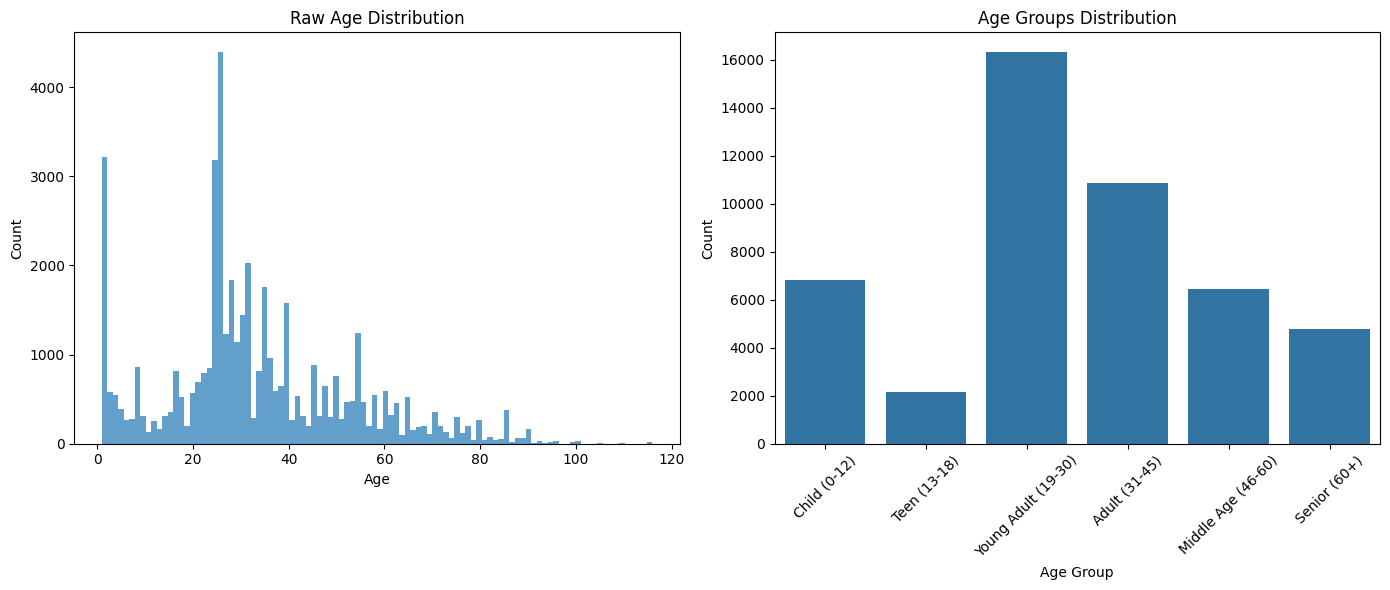

Training set: 34253 images
Validation set: 6045 images
Test set: 7112 images


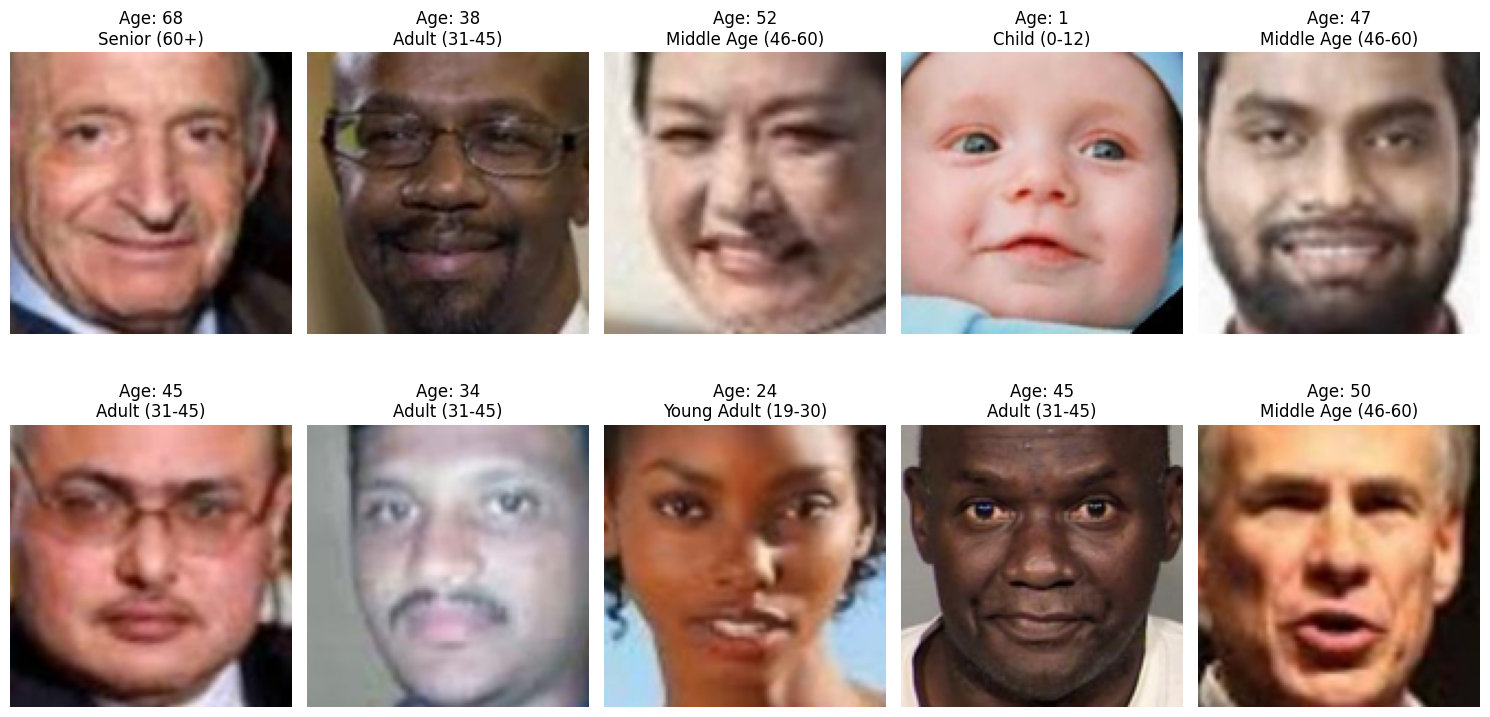

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 128, 128, 32)      │             896 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 128, 128, 32)      │             128 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 128, 128, 32)      │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 128, 128, 32)      │           9,248 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 128, 128, 32)      │             128 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 128, 128, 32)      │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 128, 128, 32)      │           9,248 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 128, 128, 32)      │             128 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 128, 128, 32)      │               0 │ batch_normalization_2[0][… │
│                               │                           │                 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 128, 128, 32)      │               0 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 64, 64, 32)        │               0 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 64, 64, 32)        │               0 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 64, 64, 64)        │          18,496 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 64, 64, 64)        │             256 │ conv2d_4[0][0]             │
│ (BatchNormalization)          │                           │               

 Total params: 673,158 (2.57 MB)

 Trainable params: 671,174 (2.56 MB)

 Non-trainable params: 1,984 (7.75 KB)


Starting model training...
Epoch 1/50
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 2463s 2s/step - accuracy: 0.3407 - loss: 1.7080 - val_accuracy: 0.4222 - val_loss: 1.7485 - learning_rate: 0.0010
Epoch 2/50
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 2580s 2s/step - accuracy: 0.5126 - loss: 1.2075 - val_accuracy: 0.4849 - val_loss: 1.3460 - learning_rate: 0.0010
Epoch 3/50
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 2624s 2s/step - accuracy: 0.5632 - loss: 1.0684 - val_accuracy: 0.5009 - val_loss: 1.2123 - learning_rate: 0.0010
Epoch 4/50
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 2460s 2s/step - accuracy: 0.5826 - loss: 1.0009 - val_accuracy: 0.5074 - val_loss: 1.1598 - learning_rate: 0.0010
Epoch 5/50
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 2412s 2s/step - accuracy: 0.5999 - loss: 0.9632 - val_accuracy: 0.5765 - val_loss: 1.0393 - learning_rate: 0.0010
Epoch 6/50
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 2521s 2s/step - accuracy: 0.6043 - loss: 0.9451 - val_accuracy: 0.6002 - val_loss: 0.9559 - learning_rate: 0.0010
Epoch 7/50
1071/1071 ━━━━━━━━━━━━━━━

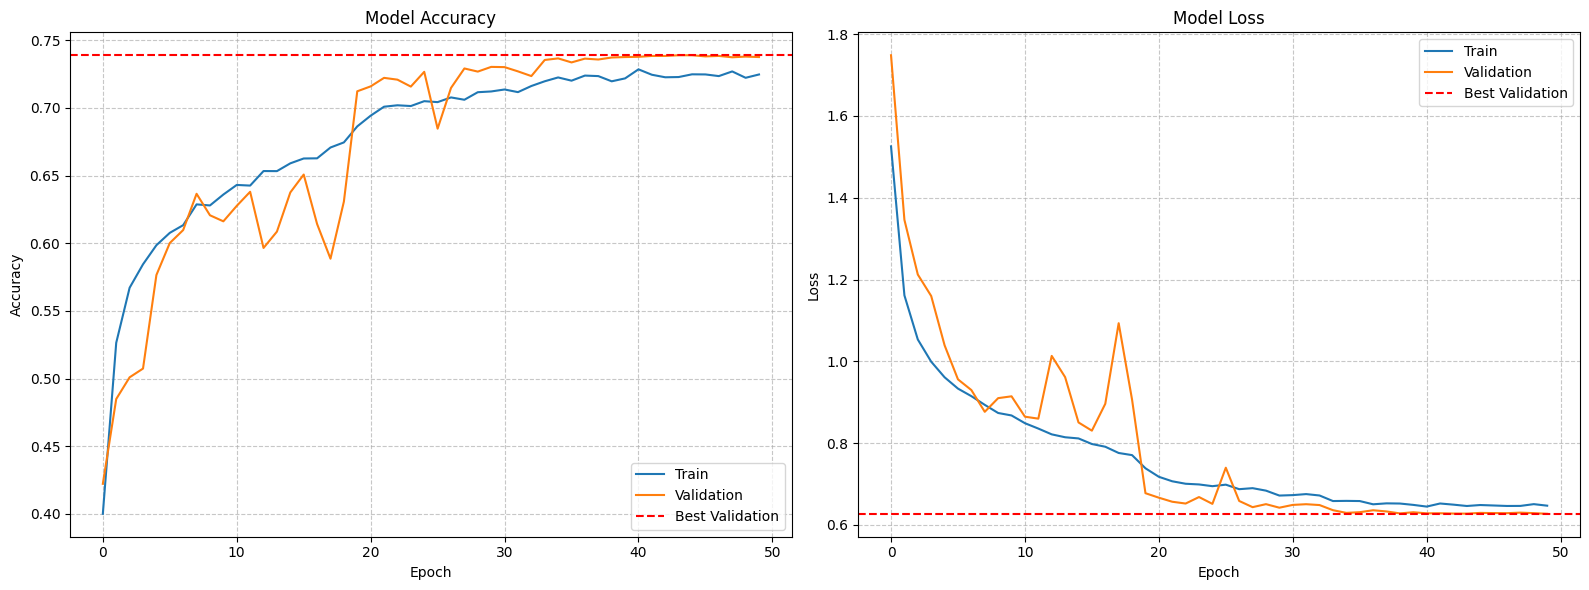

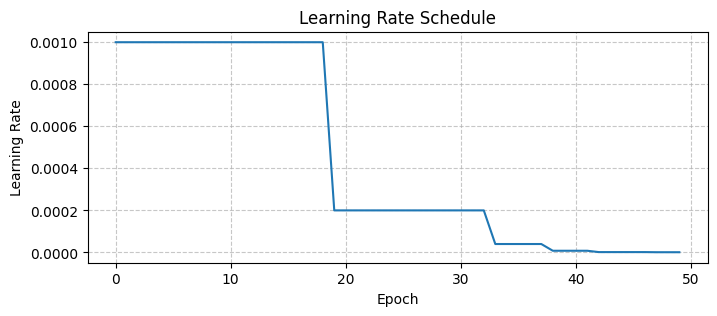

Loading best model for evaluation...
Evaluating on test set...
223/223 ━━━━━━━━━━━━━━━━━━━━ 92s 408ms/step - accuracy: 0.7360 - loss: 0.6358
Test loss: 0.6510
Test accuracy: 0.7303
Generating predictions for evaluation...


100%|████████████████████████████████████████████████████████████████████████████████| 223/223 [01:57<00:00,  1.89it/s]


Classification Report:
                     precision    recall  f1-score   support

       Child (0-12)       0.96      0.90      0.93      1024
       Teen (13-18)       0.64      0.54      0.58       325
Young Adult (19-30)       0.74      0.85      0.79      2450
      Adult (31-45)       0.60      0.55      0.57      1630
 Middle Age (46-60)       0.66      0.55      0.60       965
       Senior (60+)       0.78      0.82      0.80       718

           accuracy                           0.73      7112
          macro avg       0.73      0.70      0.71      7112
       weighted avg       0.73      0.73      0.73      7112



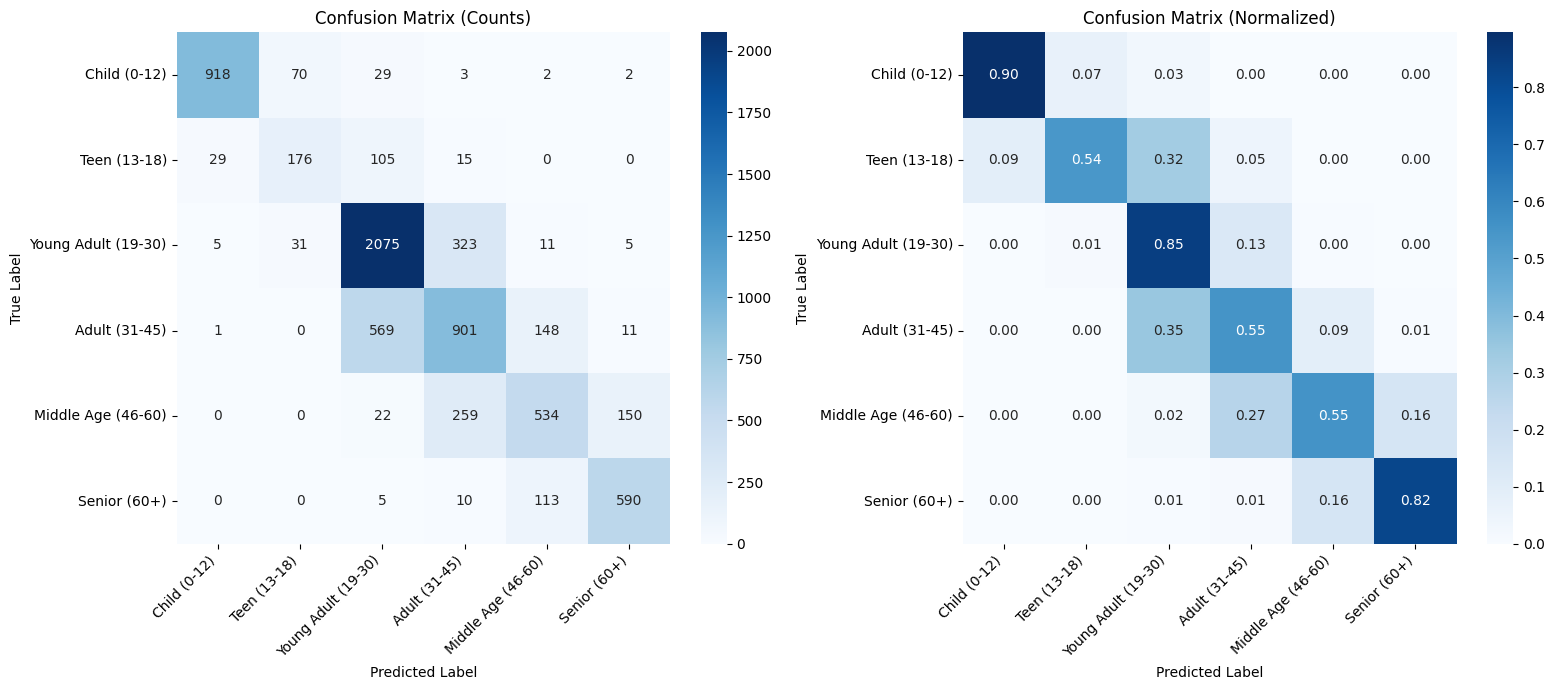

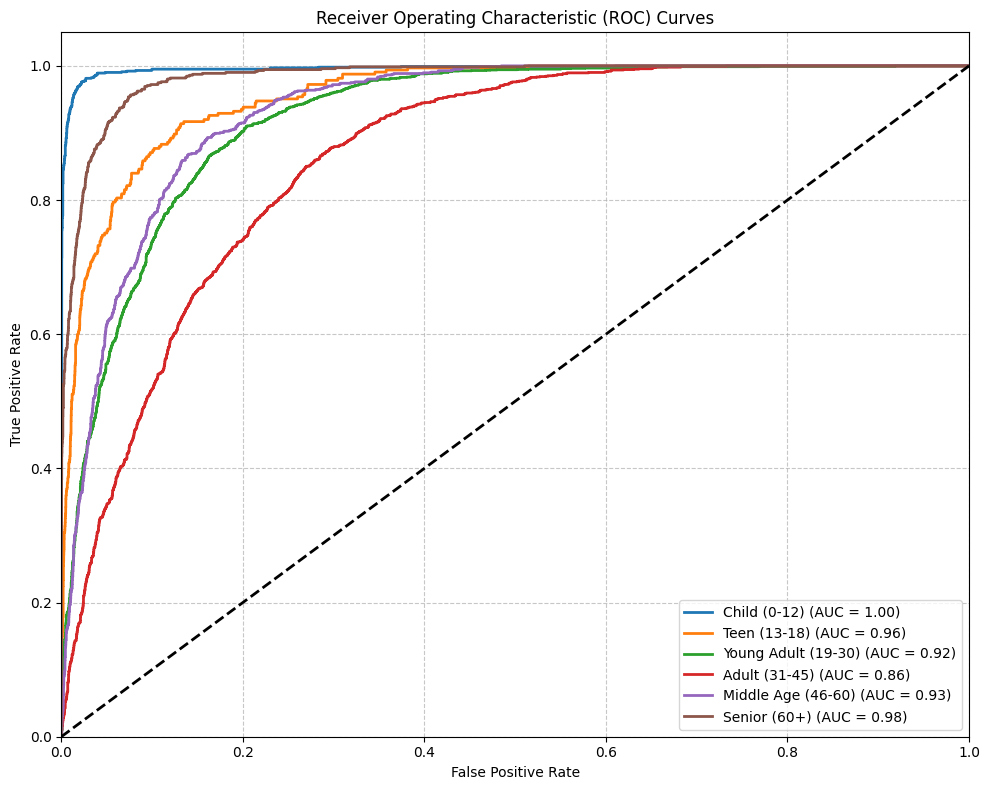

Converting model to TFLite format...
INFO:tensorflow:Assets written to: C:\Users\DAVINW~1\AppData\Local\Temp\tmpv8x_e0yy\assets


INFO:tensorflow:Assets written to: C:\Users\DAVINW~1\AppData\Local\Temp\tmpv8x_e0yy\assets


Saved artifact at 'C:\Users\DAVINW~1\AppData\Local\Temp\tmpv8x_e0yy'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  2627134225104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2627134223568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2627084013584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2627084013008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2627134223760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2627134225488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2627084012624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2627084012048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2627135511376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2627135513296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  262

In [15]:
if __name__ == "__main__":
    # Run the enhanced training
    model, class_names, df_info = main_enhanced()